In [1]:
def calc_ratio(array,vid=None,save = False):
    if save:
        plt.plot(array)
    x = scipy.signal.find_peaks(-array,distance=32)[0]
    ratios = []
    for i in range(0,len(x)):
        if save:
            plt.scatter(x[i],array[x[i]],color='orange')
        if i==len(x)-1:
            y = np.argmax(array[x[i]:])
        else:
            y = np.argmax(array[x[i]:x[i+1]])
        if save:
            plt.scatter(y+x[i],array[y+x[i]],color='red')
        x_val = array[x[i]]
        y_val = array[y+x[i]]
        ratios.append(x_val/y_val)
    if save:
        plt.savefig(os.path.join('Ratio_Calc',vid[:-4]+'.png'))
    return ratios

In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy.signal
from scipy.stats import linregress

# Plots of frame lengths

If you notice, there is some error along the sides, but in general a strong linear path

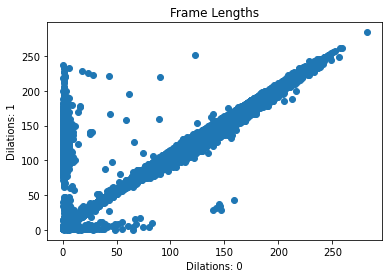

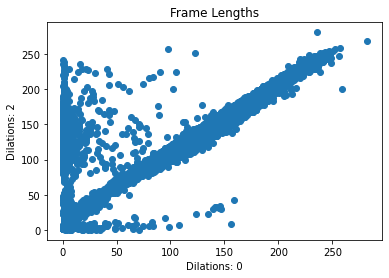

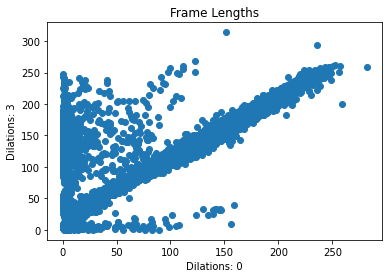

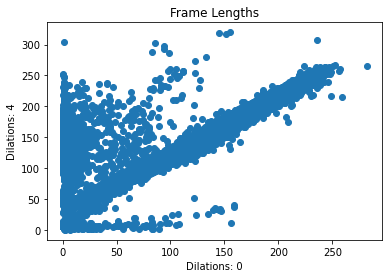

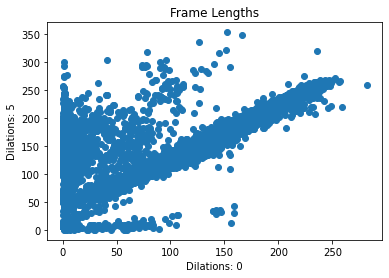

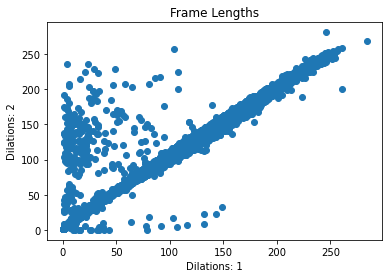

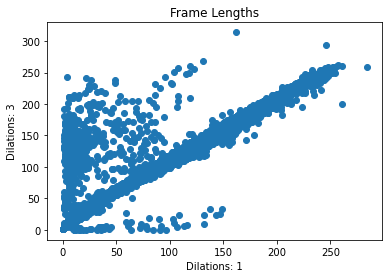

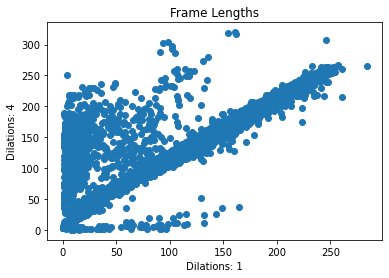

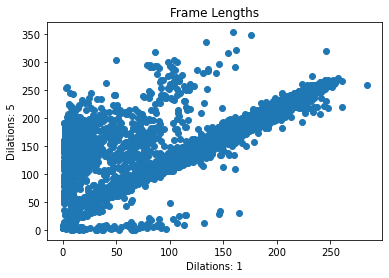

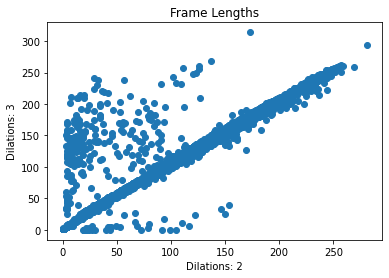

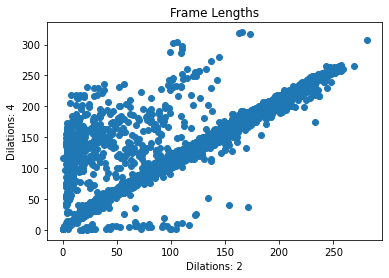

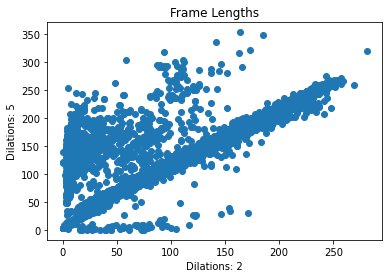

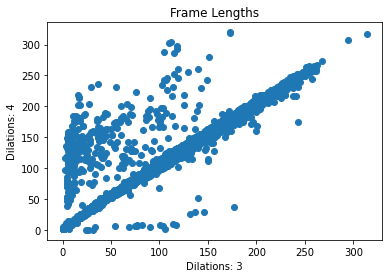

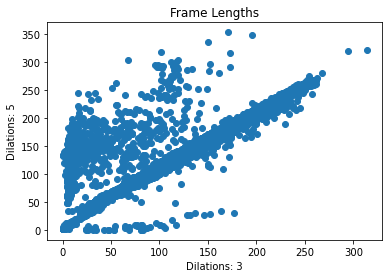

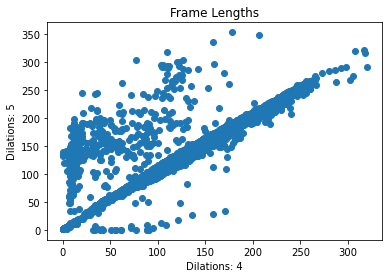

In [9]:
for i in range(0,6):
    df1 = pd.read_csv('J:\\Strain Dilation Results\\Strain_Single_Script_thin_'+str(i)+'\\Strain.csv')
    df1['filenames_frame'] = df1.filenames + df1.frame_num.astype(str)
    df1['l1'] = df1.length
    df1 = df1.set_index('filenames_frame')
    for j in range(i+1,6):
        if not i==j:
            df2 = pd.read_csv('J:\\Strain Dilation Results\\Strain_Single_Script_thin_'+str(j)+'\\Strain.csv')
            df2['filenames_frame'] = df2.filenames + df2.frame_num.astype(str)
            df2['l2'] = df2.length
            df2 = df2.set_index('filenames_frame')
            df_final = df1[['filenames','frame_num','l1']].join(df2[['l2']])
            #df_final = df1[['filenames','frame_num','l1']].join(df2[['l2']])
            plt.scatter(df_final.l1,df_final.l2)
            plt.title("Frame Lengths")
            plt.xlabel('Dilations: '+str(i))
            plt.ylabel('Dilations: '+str(j))
            plt.show()


In [10]:
mean_ratios = pd.DataFrame()
for i in range(0,6):
    df = pd.read_csv('J:\\Strain Dilation Results\\Strain_Single_Script_thin_'+str(i)+'\\Strain.csv')
    ratio = []
    for j in tqdm(df.filenames.unique()):
        temp = df[df.filenames==j].reset_index().length
        ratio.append(np.mean(calc_ratio(temp)))
    mean_ratios = mean_ratios.append(pd.Series(data = ratio, index = df.filenames.unique(),name='Dilations: '+str(i)))

100%|██████████████████████████████████████████████████████████████████████████████| 3213/3213 [01:34<00:00, 34.01it/s]


In [11]:
mean_ratios = mean_ratios.transpose()

In [12]:
mean_ratios.head()

,Dilations: 0,Dilations: 1,Dilations: 2,Dilations: 3,Dilations: 4,Dilations: 5
0X10D278E3FD2DE072.avi,0.538873,0.683666,0.709524,0.720090,0.723764,0.719170
0X10D5F8CF0EB124.avi,0.558350,0.864708,0.869210,0.904991,0.900268,0.888196
0X10D734CBEB6ECB81.avi,0.709677,0.838384,0.737864,0.733945,0.730435,0.704000
0X10D8F5659B144070.avi,0.843637,0.857977,0.846996,0.855779,0.843210,0.820449
0X10DEF75CF6DC6B84.avi,0.548909,0.741291,0.755574,0.759364,0.760531,0.759411


# Now checking out the actual results, the predicted ratio

0 dilations perform a lot worse than the others, the others all perform about the same

In [13]:
mean_ratios.to_csv("Dilation_Results.csv")

In [14]:
from statsmodels.regression import linear_model

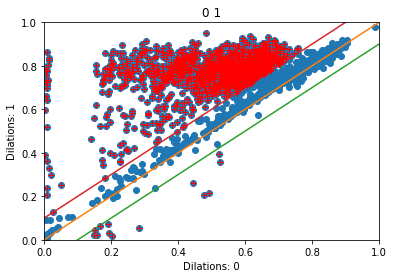

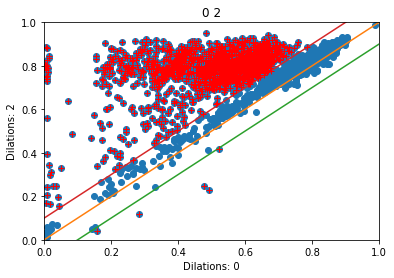

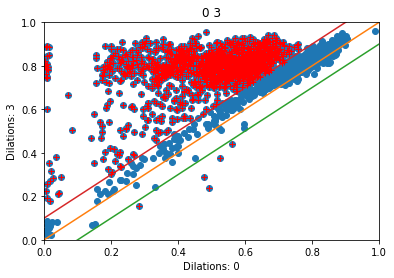

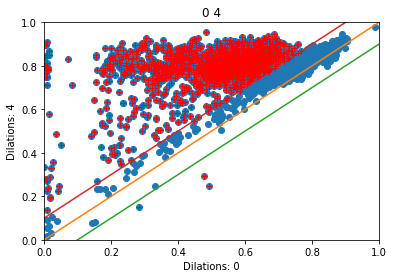

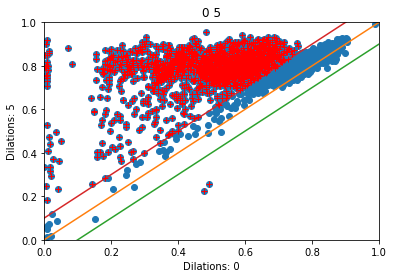

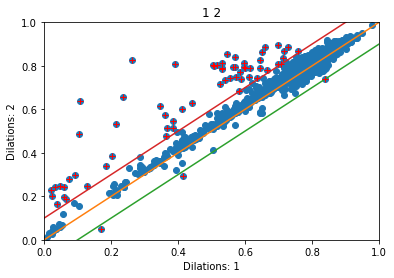

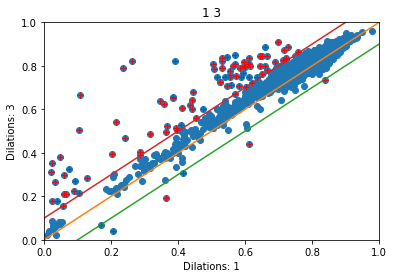

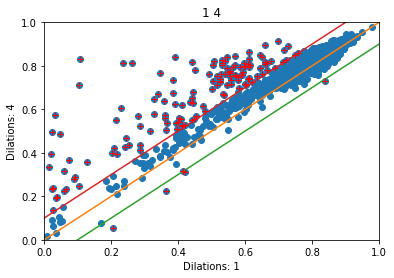

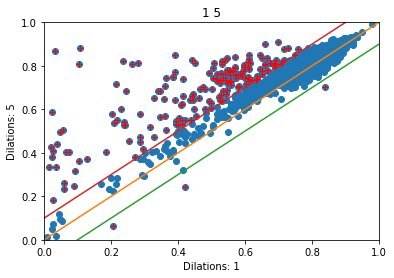

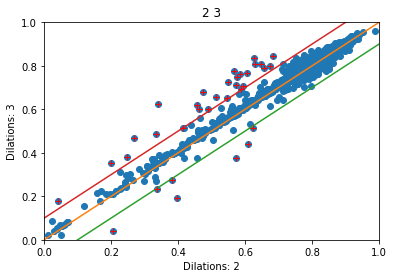

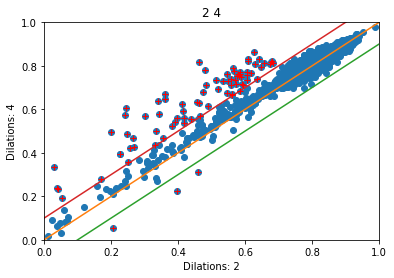

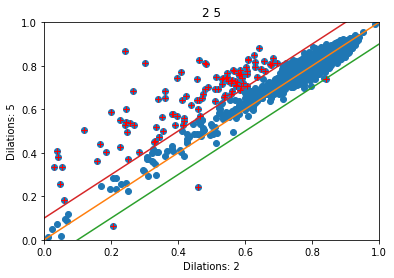

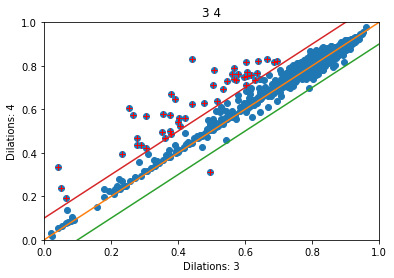

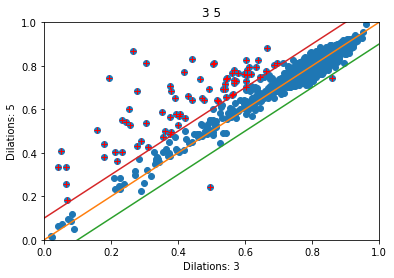

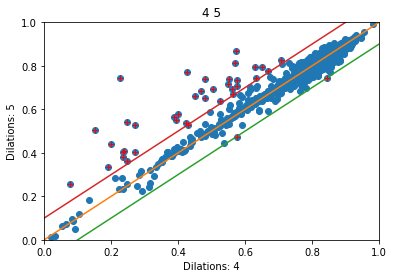

In [46]:
from statsmodels.stats.outliers_influence import summary_table
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
outlying_files = []
for i in range(0,6):
    outlying_files.append([])
    for j in range(i+1,6):
        if i== 0:
            temp = mean_ratios.copy()
            temp = temp.dropna()
            x,y = temp['Dilations: '+str(i)],temp['Dilations: '+str(j)]
            file_name_list = temp.index
        else:
            x,y = mean_ratios['Dilations: '+str(i)],mean_ratios['Dilations: '+str(j)]
            file_name_list = mean_ratios.index
        re = sm.OLS(y, x).fit()
        prstd, iv_l, iv_u = wls_prediction_std(re)

        st, data, ss2 = summary_table(re, alpha=0.05)

        fittedvalues = data[:, 2]
        predict_mean_se  = data[:, 3]
        predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
        predict_ci_low, predict_ci_upp = data[:, 6:8].T

        # Check we got the right things

        plt.plot(x, y, 'o')
        plt.title(str(i)+" "+str(j))
        plt.xlabel('Dilations: '+str(i))
        plt.ylabel('Dilations: '+str(j))
        plt.xlim([0,1])
        plt.ylim([0,1])
        #plt.plot(x, fittedvalues, '-', lw=2)
        plt.plot(np.linspace(0,1),np.linspace(0,1))
        plt.plot(np.linspace(0,1),np.linspace(0,1)-.1)
        plt.plot(np.linspace(0,1),np.linspace(0,1)+.1)
        #plt.plot(x, predict_ci_low, 'r--', lw=2)
        #plt.plot(x, predict_ci_upp, 'r--', lw=2)
        for j in range(0,len(y)):
            if (y[j]<x[j]-.1) or (y[j]>x[j]+.1):
                plt.plot(x[j],y[j],'r+')
                outlying_files[-1].append(file_name_list[j])
        #plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
        #plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
        plt.show()


The outliers can be found at

J:\Strain Dilation Results\outliers

Each subfolder has the outliers identified in plots where that number of dilations was the x axis.

As the plotting format went:
    0-1
    0-2
    ...
    4-5
    
You are best off identifying the ones in 0 and in 1, as 0 over identifies outliers, and once you exclude 0 from the set, the number of outliers falls by an order of magnitude

In [50]:
import subprocess
from shutil import copyfile
import os.path as path
for i in range(0,6):
    for j in tqdm(outlying_files[i]):
        directory = os.path.join('J:\Strain Dilation Results\Strain_Single_Script_thin_'+str(i),'Strain_Videos',j)
        dest = os.path.join('J:\\Strain Dilation Results\\outliers\\Dilation '+str(i),j)
        if path.exists(directory):
            copyfile(directory,dest)


100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 630.76it/s]
0it [00:00, ?it/s]


In [51]:
import subprocess
from shutil import copyfile
import os.path as path
for i in range(0,6):
    for j in tqdm(outlying_files[i]):
        directory = os.path.join('J:\Strain Dilation Results\Strain_Single_Script_thin_'+str(i),'Strain_Plots',j[:-4]+'.png')
        dest = os.path.join('J:\\Strain Dilation Results\\outliers\\Plot '+str(i),j[:-4]+'.png')
        if path.exists(directory):
            copyfile(directory,dest)

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1154.31it/s]
0it [00:00, ?it/s]


In [49]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
len(outlying_files[1])

12852

In [52]:
total_outliers = []
for i in outlying_files[1:]:
    for j in i:
        if not j in total_outliers:
            total_outliers.append(j)

In [54]:
len(total_outliers)

200